<a href="https://colab.research.google.com/github/visualdatabase/fastdup/blob/main/examples/fastdup_wrong_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fastdup for finding wrong or confusing labels 
In this notebook we will learn how to identify wrong labels using image similarity. We first embed the images into short feature vectors and build a nearest neighbor model using fastdup. Next we use k-nearest neighbor classifier to score images that are more similar to other classes using fastdup `create_similarity_gallery()` method.

In [17]:
#install fastdup
!pip install -U --force-reinstall fastdup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 38.8 MB 1.4 MB/s 
     |████████████████████████████████| 78 kB 7.8 MB/s 
     |████████████████████████████████| 11.3 MB 43.2 MB/s 
     |████████████████████████████████| 596 kB 40.3 MB/s 
     |████████████████████████████████| 60.9 MB 121 kB/s 
     |████████████████████████████████| 15.7 MB 41.1 MB/s 
     |████████████████████████████████| 503 kB 52.7 MB/s 
     |████████████████████████████████| 247 kB 52.3 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.2
    Uninstalling python-dateutil-2.8.2:
      Succes

In [2]:
#download a subset of the food-101 dataset containing soup images
!gdown 1_iHtUfN8Q01y2PsOuTOclXELkY9gClEZ

Downloading...
From: https://drive.google.com/uc?id=1_iHtUfN8Q01y2PsOuTOclXELkY9gClEZ
To: /content/soups.zip
100% 135M/135M [00:01<00:00, 97.7MB/s]


In [3]:
!unzip -qq soups.zip

In [1]:
import fastdup

In [72]:
!rm -fr out
!python -c "import fastdup; fastdup.run('food-101', work_dir='out',nearest_neighbors_k=10,threshold=0.9)"

FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.
On Jupyter notebook running on large datasets, there may be delay getting the console output. We recommend running using python shell.
Going to loop over dir food-101
Found total 3000 images to run on
Wrote total of 3000 features , found 0 bad images
Found total 3000 images to run on
1074) Finished write_index() NN model
Stored nn model index file out/nnf.index
1659343769 : INFO:     (add_vertices:460): Num vertices for group 0: 3000
1659343769 : INFO:     (commit_edge_buffer:609): In commit edge buffer (0,0)
1659343769 : INFO:     (commit_edge_buffer:680): Shuffling edges ...
1659343769 : INFO:     (commit_edge_buffer:688): Done shuffling edges in 0.007684 secs
1659343769 : INFO:     (commit_edge_buffer:692): Aggregating unique vertices...
1659343769 : INFO:     (commit_edge_buffer:705): Done aggregating unique vertex in 0.001379 secs
1659343769 : INFO:     (commit_edge_buffer:713): Combine vertex data
16593437

In [83]:
import cv2
import numpy as np
import pandas as pd
from fastdup.image import plot_bounding_box, my_resize, imageformatter
from fastdup.galleries import slice_df
from tqdm import tqdm
import traceback
import os

def do_create_similarity_gallery(similarity_file, save_path, num_images=20, lazy_load=False, get_label_func=None,
                                 slice=None, max_width=None, descending=False, get_bounding_box_func =None,
                                 get_reformat_filename_func=None, get_extra_col_func=None):
    '''

    Function to create and display a gallery of images computed by the outliers metrics

    Parameters:
        stats_file (str): csv file with the computed image statistics by the fastdup tool

        save_path (str): output folder location for the visuals

        num_images(int): Max number of images to display (default = 50). Be careful not to display too many images at once otherwise the notebook may go out of memory.

        lazy_load (boolean): If False, write all images inside html file using base64 encoding. Otherwise use lazy loading in the html to load images when mouse curser is above the image (reduced html file size).

        get_label_func (callable): Optional parameter to allow adding more image information to the report like the image label. This is a function the user implements that gets the full file path and returns html string with the label or any other metadata desired.

        metric (str): Optional metric selection. One of blur, size, mean_value

        slice (str or list): Optional parameter to select a slice of the outliers file based on a specific label or a list of labels.

        max_width (int): Optional param to limit the image width

        descending (bool): Optional param to control the order of the metric

        get_bounding_box_func (callable): Optional parameter to allow adding bounding box to the image. This is a function the user implements that gets the full file path and returns a bounding box or an empty list if not available.

        get_reformat_filename_func (callable): Optional parameter to allow reformatting the filename before displaying it in the report. This is a function the user implements that gets the full file path and returns a string with the reformatted filename.

        get_extra_col_func (callable): Optional parameter to allow adding more image information to the report like the image label. This is a function the user implements that gets the full file path and returns html string with the label or any other metadata desired.

     '''


    from fastdup import generate_sprite_image
    img_paths = []
    img_paths2 = []
    info0 = []
    info = []
    label_score = []
    lengths = []

    df = pd.read_csv(similarity_file)
    assert len(df), "Failed to read stats file " + similarity_file

    if callable(get_label_func):
        df['label'] = df['from'].apply(lambda x: get_label_func(x))
        df['label2'] = df['to'].apply(lambda x: get_label_func(x))
        if slice != 'label_score':
          df = slice_df(df, slice)

    df = df.sort_values(['from','distance'], ascending= not descending)
    if 'label' in df.columns:
        top_labels = df.groupby('from')['label2'].apply(list)

    tos = df.groupby('from')['to'].apply(list)
    distances = df.groupby('from')['distance'].apply(list)

    if 'label' in df.columns:
        subdf = pd.DataFrame({'to':tos, 'label':top_labels,'distance':distances}).reset_index()
    else:
        subdf = pd.DataFrame({'to':tos, 'distance':distances}).reset_index()

    if slice is None or slice != 'label_score':
        subdf = subdf.head(num_images)
    else:
        for i, row in tqdm(subdf.iterrows(), total=len(subdf)):
            filename = row['from']
            label = get_label_func(filename)
            similar = [x==label for x in list(row['label'])]
            similar = 100.0*sum(similar)/(1.0*len(row['label']))
            lengths.append(len(row['label']))
            label_score.append(similar)
        subdf['score'] = label_score
        subdf['length'] = lengths
        print(subdf['score'].describe())
        subdf = subdf[subdf['length'] > 1]
        subdf = subdf.sort_values(['score','length'], ascending=not descending)
        subdf = subdf.head(num_images)
          
    for i, row in tqdm(subdf.iterrows(), total=min(num_images, len(subdf))):
        try:
            filename = row['from']
            label = get_label_func(filename)
            if callable(get_reformat_filename_func):
                new_filename = get_reformat_filename_func(filename)
            else:
                new_filename = filename

            if 'label' in row:
                info0_df = pd.DataFrame({'label':[label],'from':[new_filename]}).T
            else:
                info0_df = pd.DataFrame({'from':[new_filename]}).T

            info0.append(info0_df.to_html(header=False,escape=False).replace('\n',''))


            img = cv2.imread(filename)
            img = plot_bounding_box(img, get_bounding_box_func, filename)
            img = my_resize(img, max_width)

            imgpath = os.path.join(save_path, filename.replace('/',''))
            p, ext = os.path.splitext(imgpath)
            if ext is not None and ext != '' and ext.lower() not in ['png','tiff','tif','jpeg','jpg','gif']:
                imgpath += ".jpg"

            cv2.imwrite(imgpath, img)
            assert os.path.exists(imgpath), "Failed to save img to " + imgpath

            MAX_IMAGES = 10
            imgs = row['to'][:MAX_IMAGES]
            distances = row['distance'][:MAX_IMAGES]
            imgpath2 = f"{save_path}/to_image_{i}.jpg"
            info_df = pd.DataFrame({'distance':distances, 'to':imgs})


            if callable(get_reformat_filename_func):
              info_df['to'] = info_df['to'].apply(lambda x: get_reformat_filename_func(x))

            if 'label2' in df.columns:
                info_df['label'] = row['label'][:MAX_IMAGES]
            info_df = info_df.sort_values('distance',ascending=False)
            info.append(info_df.to_html(escape=False).replace('\n',''))

            h = max_width if max_width is not None else 0
            w = h
            generate_sprite_image(imgs, min(len(imgs), MAX_IMAGES), save_path, get_label_func, h, w, imgpath2, min(len(imgs),MAX_IMAGES), max_width=max_width)
            assert os.path.exists(imgpath2)

        except Exception as ex:
            traceback.print_exc()
            print("Failed to generate viz for images", filename, ex)
            imgpath = None
            imgpath2 = None

        img_paths.append(imgpath)
        img_paths2.append(imgpath2)

    import fastdup.html_writer
    if not lazy_load:
        subdf.insert(0, 'Image', [imageformatter(x, max_width) for x in img_paths])
        subdf.insert(0, 'Similar', [imageformatter(x, None) for x in img_paths2])
    else:
        img_paths3 = ["<img src=\"" + os.path.join(save_path, os.path.basename(x)) + "\" loading=\"lazy\">" for x in img_paths]
        img_paths4 = ["<img src=\"" + os.path.join(save_path, os.path.basename(x)) + "\" loading=\"lazy\">" for x in img_paths2]
        subdf.insert(0, 'Image', img_paths3)
        subdf.insert(0, 'Similar', img_paths4)

    subdf['info_to'] = info
    subdf['info_from'] = info0

    out_file = os.path.join(save_path, 'topk_similarity.html')
    title = 'Fastdup Tool - Similarity Image Report'
    if slice is not None:
        title += ", " + str(slice)

    cols = ['info_from','info_to', 'Image','Similar']
    if slice is not None and slice == 'label_score':
      cols = ['score'] + cols
    if callable(get_extra_col_func):
        subdf['extra'] = subdf['from'].apply(lambda x: get_extra_col_func(x))
        cols.append('extra')


    fastdup.html_writer.write_to_html_file(subdf[cols], title, out_file)
    assert os.path.exists(out_file), "Failed to generate out file " + out_file

    print("Stored similar images view in ", os.path.join(out_file))
    if not lazy_load:
        for i in img_paths:
            try:
                os.unlink(i)
            except Exception as ex:
                print("Failed to delete image file ", i, ex)

In [84]:
#return the folder name which is the label of the soup class
def my_label_func(x):
  return x.split('/')[-2]

In [85]:
do_create_similarity_gallery('out/similarity.csv','.',get_label_func=my_label_func,
                             get_reformat_filename_func=lambda x: os.path.basename(x),max_width=180,slice='label_score',descending=True)

100%|██████████| 430/430 [00:00<00:00, 7677.33it/s]


count    430.000000
mean      95.288575
std       17.943400
min        0.000000
25%      100.000000
50%      100.000000
75%      100.000000
max      100.000000
Name: score, dtype: float64


100%|██████████| 20/20 [00:02<00:00,  8.30it/s]


Stored similar images view in  ./topk_similarity.html


## First we look at the best images, images that are very similar in their class


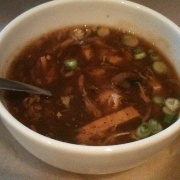
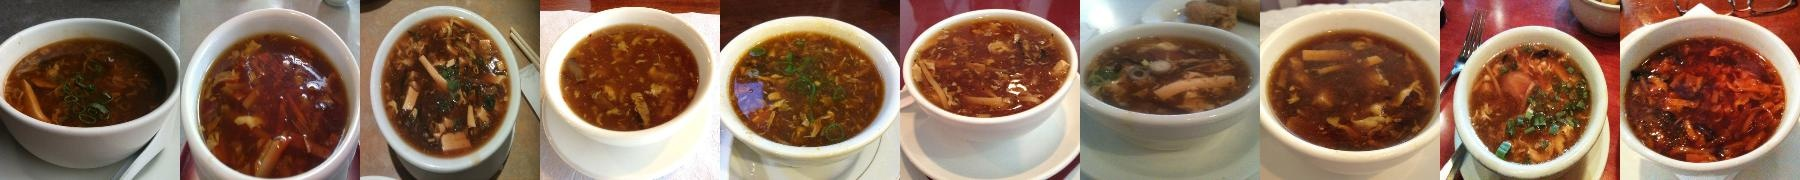
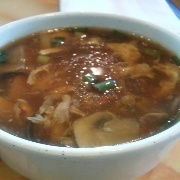
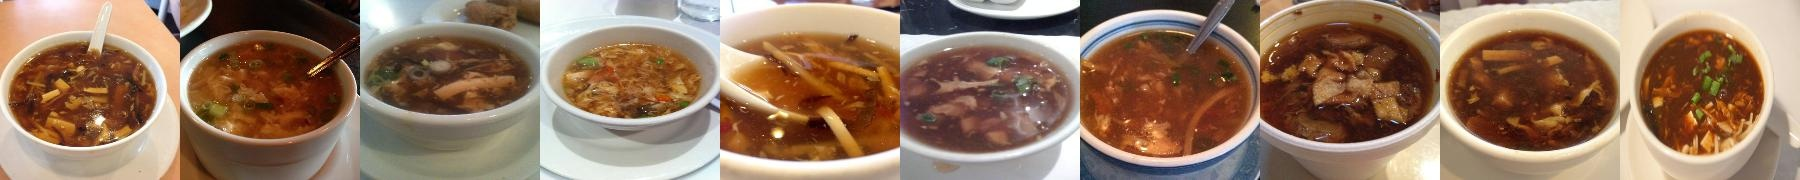
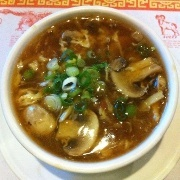
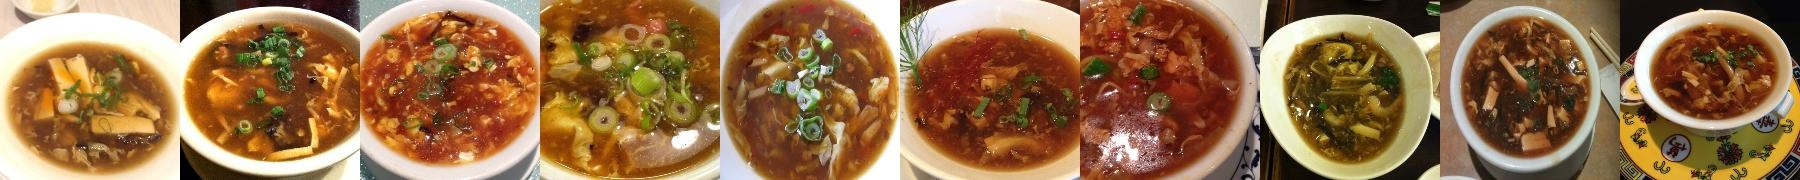
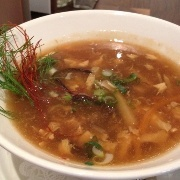
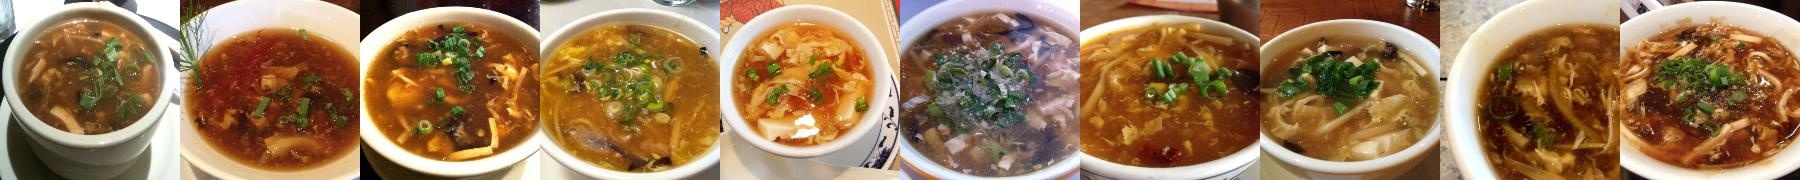
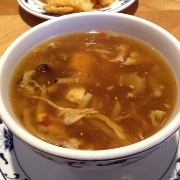
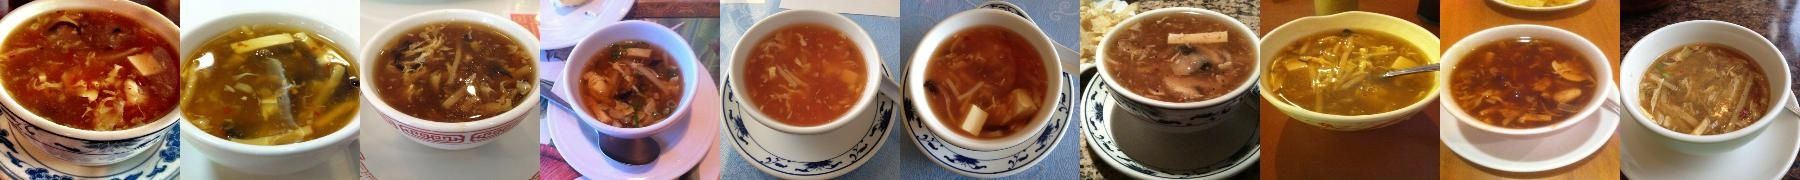
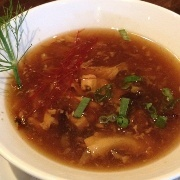
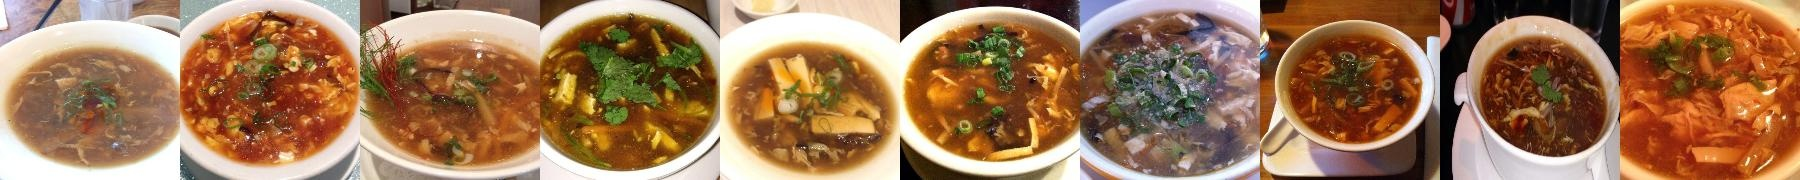
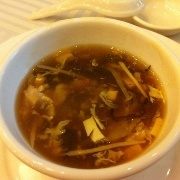
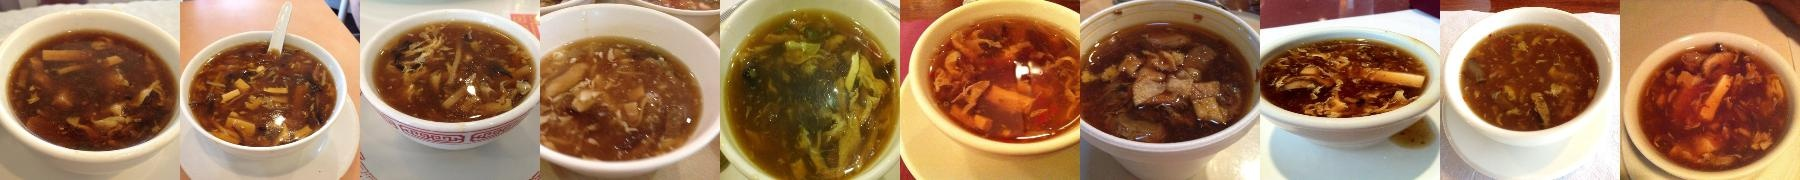
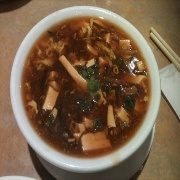
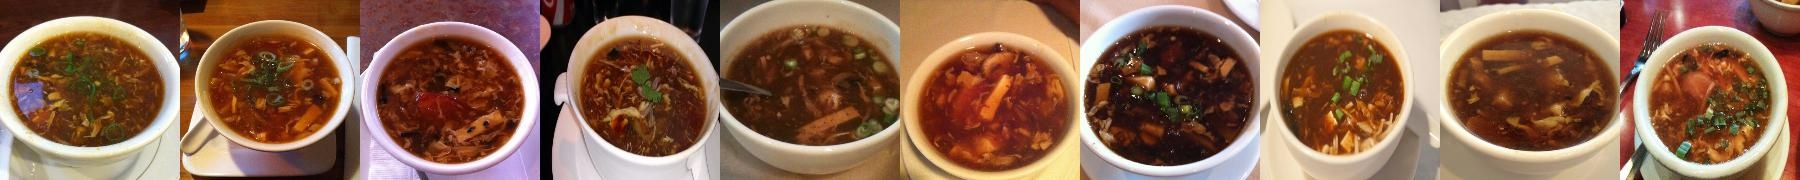
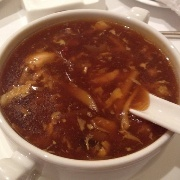
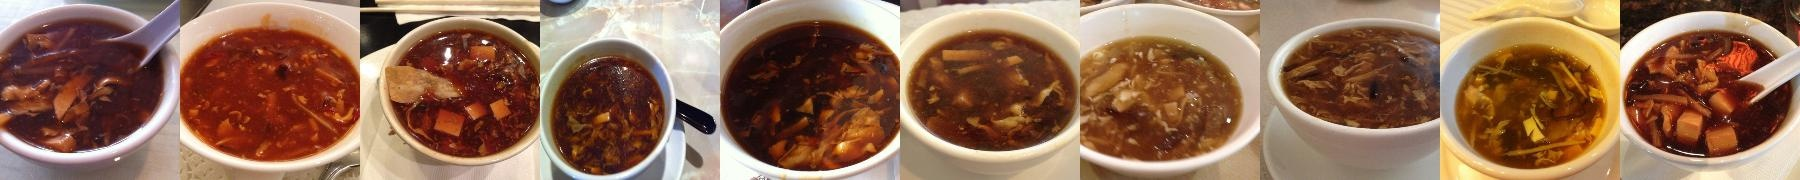
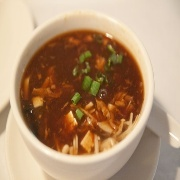
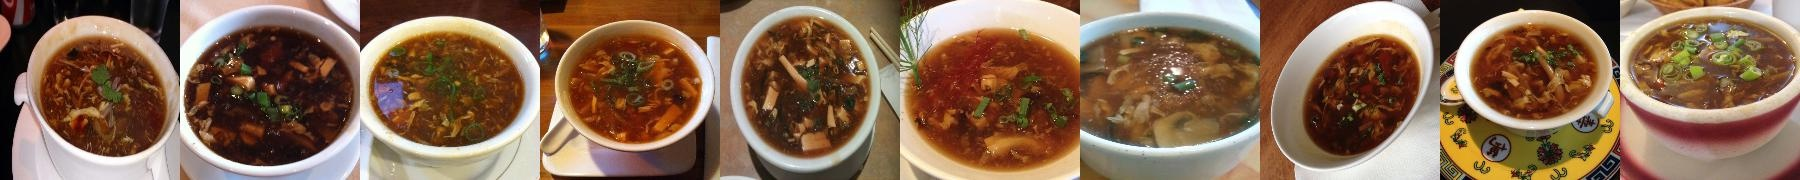
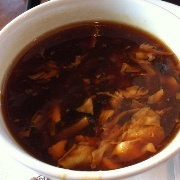
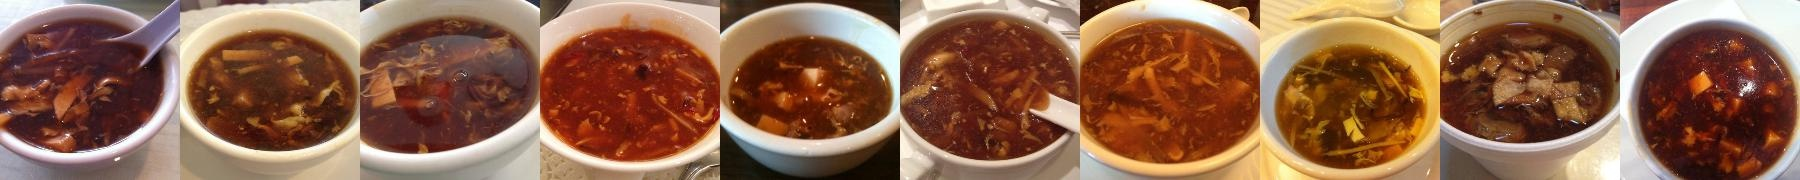
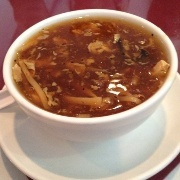
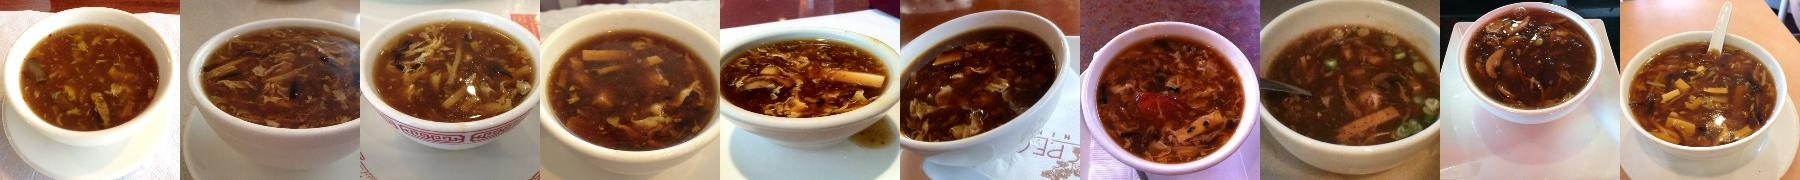
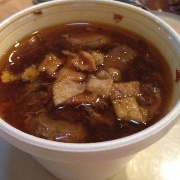
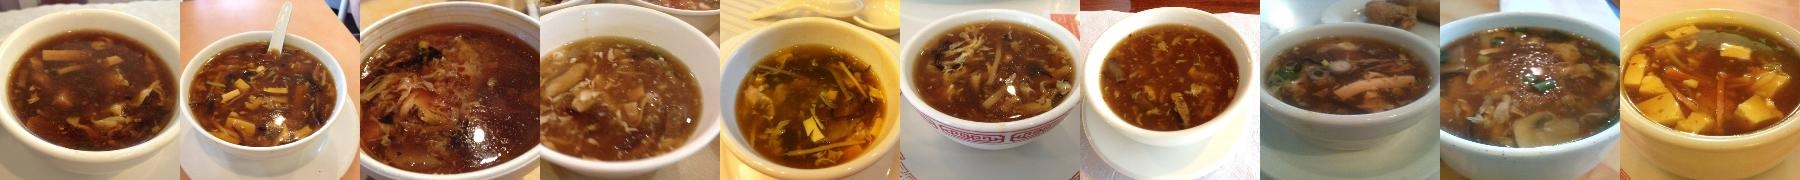
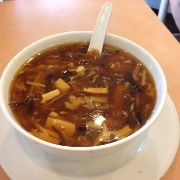
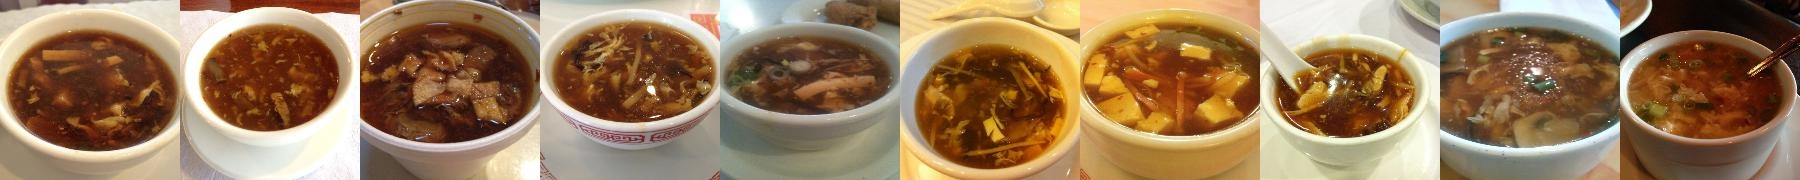
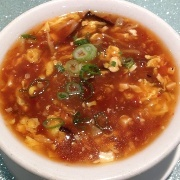
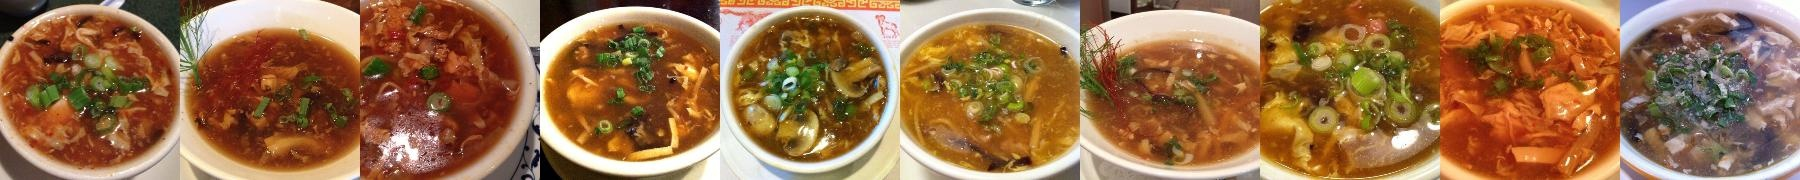
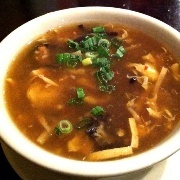
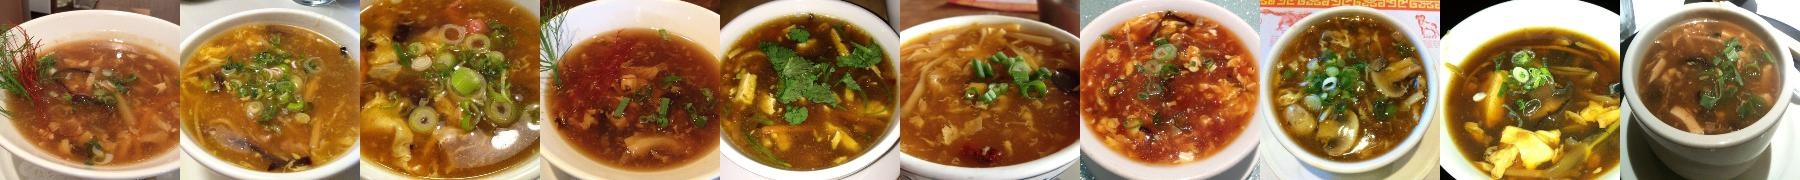
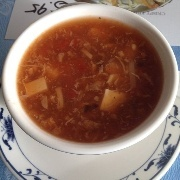
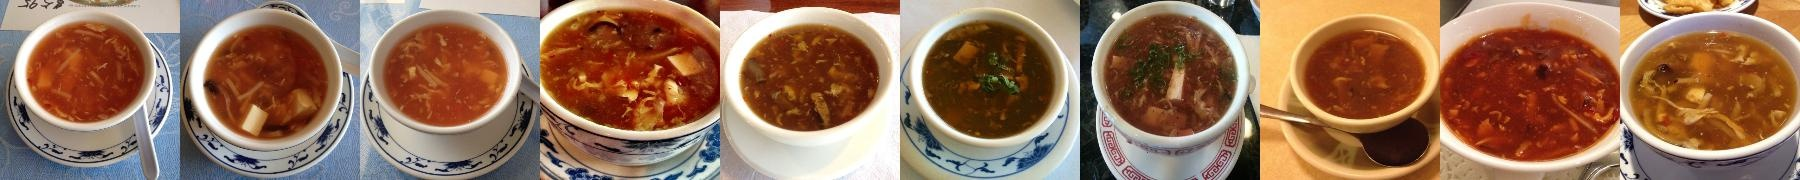
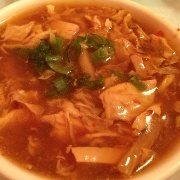
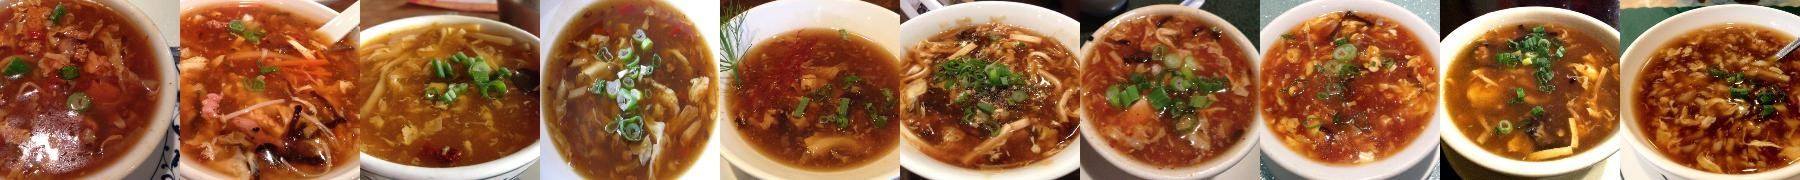
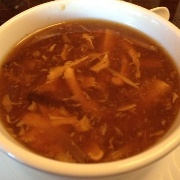
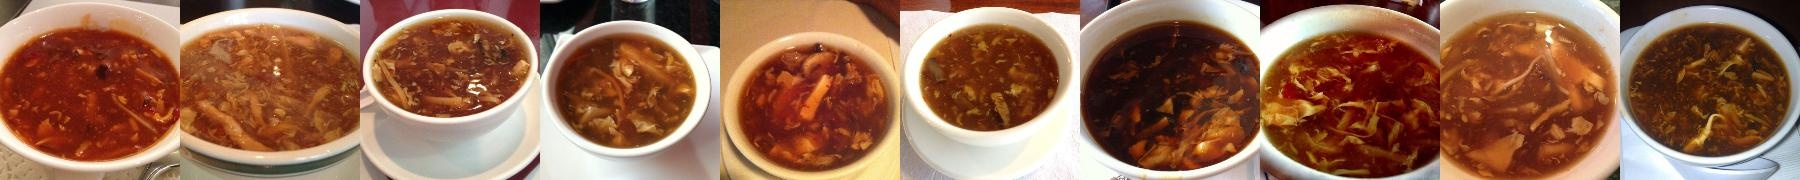
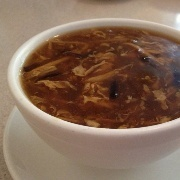
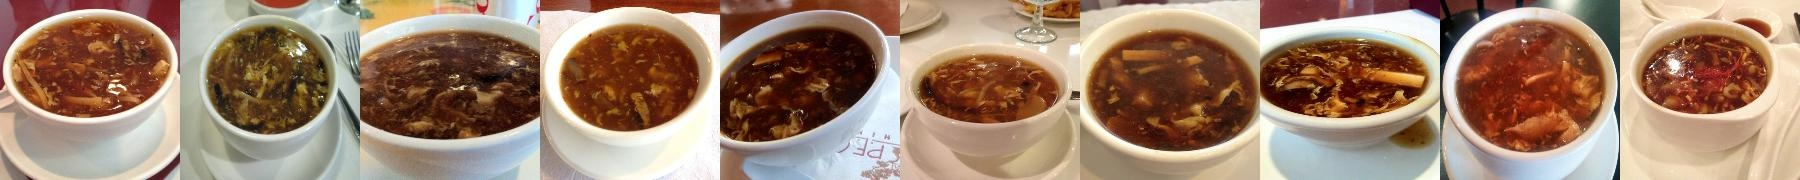

In [86]:
from IPython.display import HTML
HTML('./topk_similarity.html')

## We we examine confusing images that are not similar in their class

In [87]:
do_create_similarity_gallery('out/similarity.csv','.',get_label_func=my_label_func,
                             get_reformat_filename_func=lambda x: os.path.basename(x),max_width=180,slice='label_score',descending=False)

100%|██████████| 430/430 [00:00<00:00, 8131.87it/s]


count    430.000000
mean      95.288575
std       17.943400
min        0.000000
25%      100.000000
50%      100.000000
75%      100.000000
max      100.000000
Name: score, dtype: float64


100%|██████████| 20/20 [00:00<00:00, 23.98it/s]


Stored similar images view in  ./topk_similarity.html



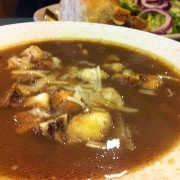
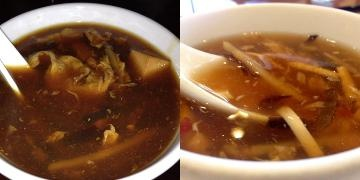
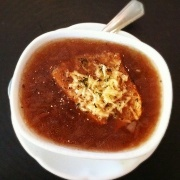
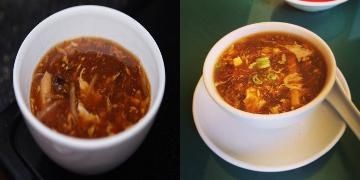
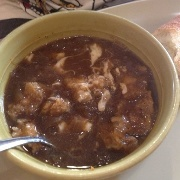
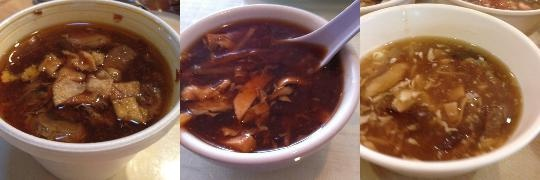
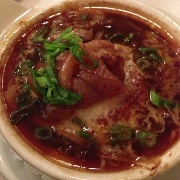
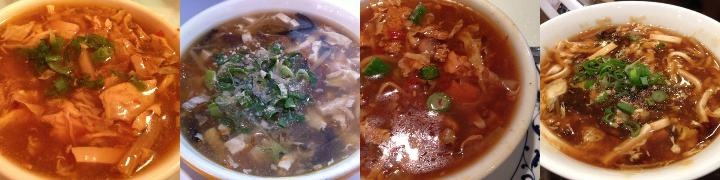
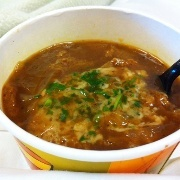
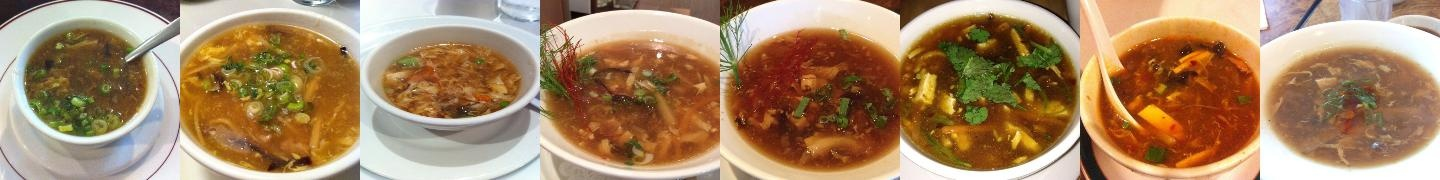
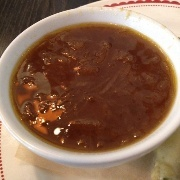
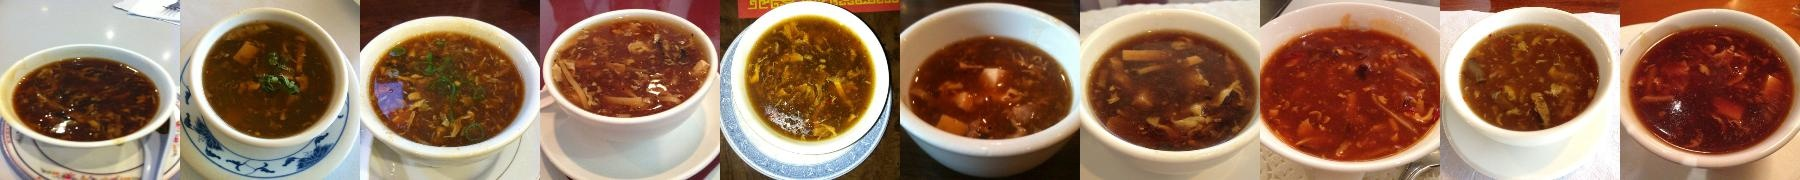
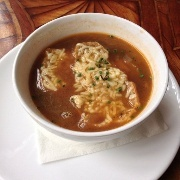
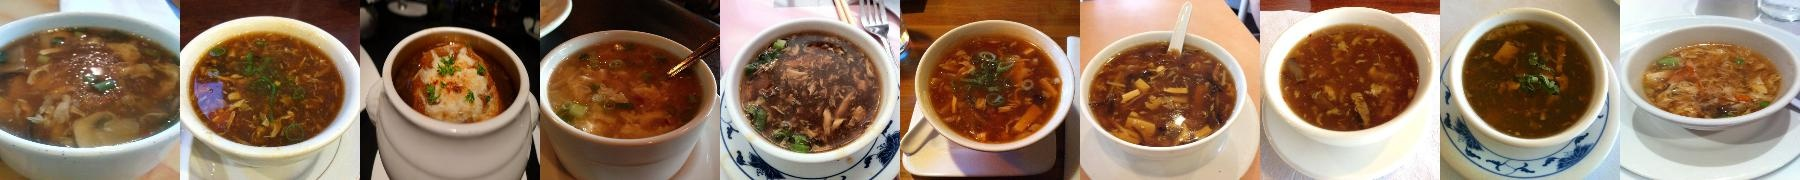
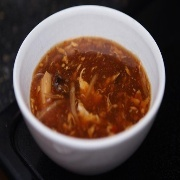
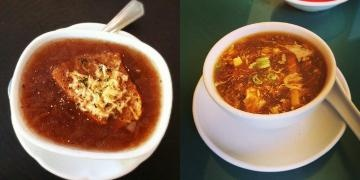
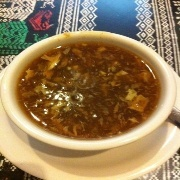
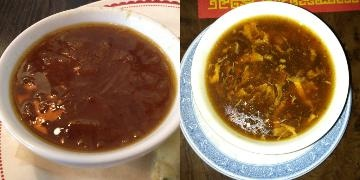
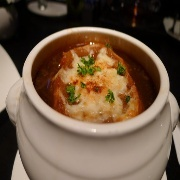
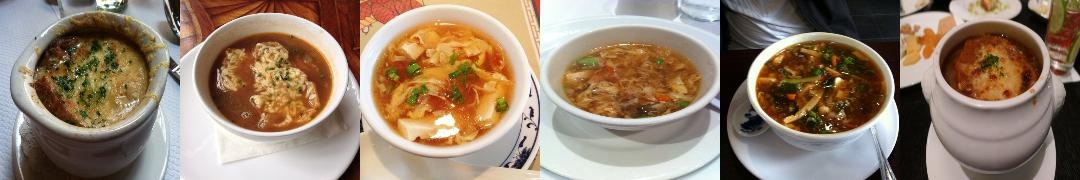
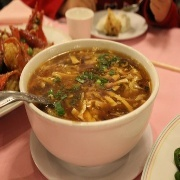
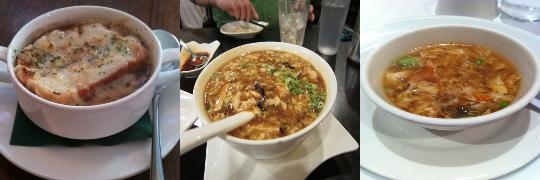
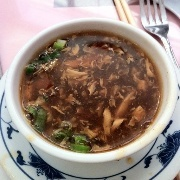
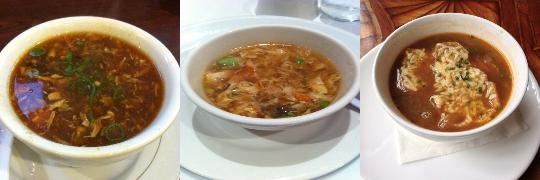
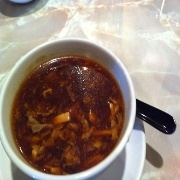
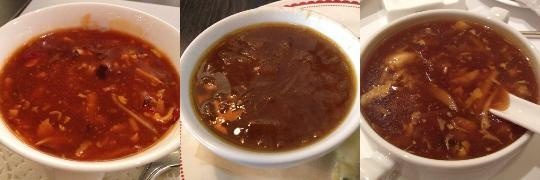
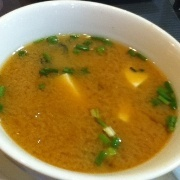
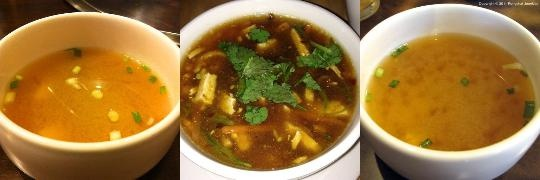
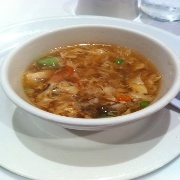
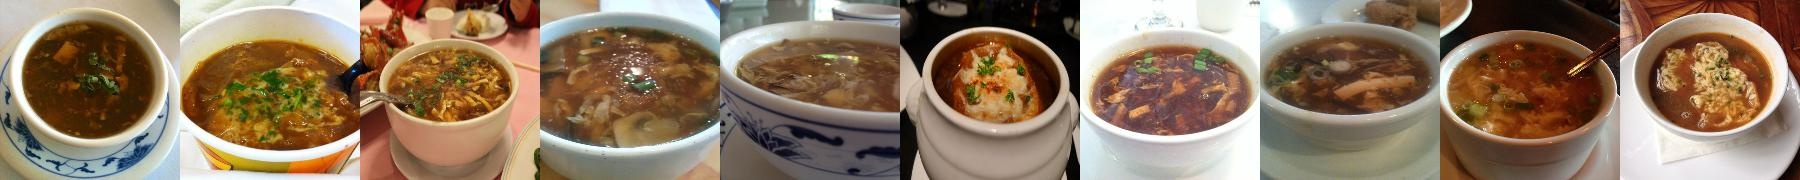
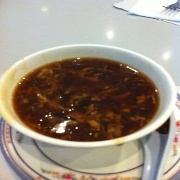
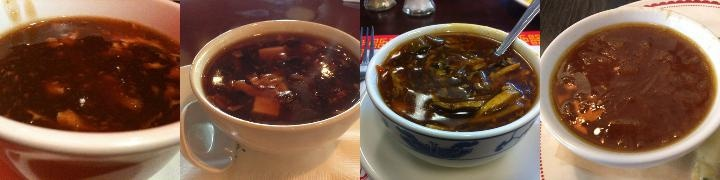
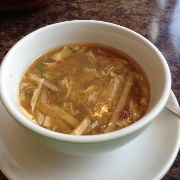
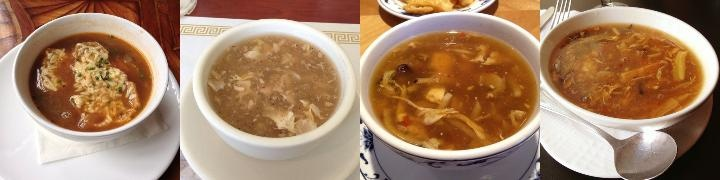
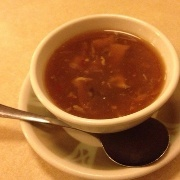
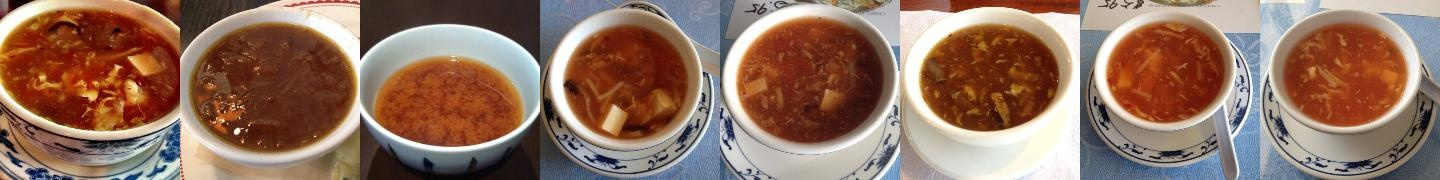
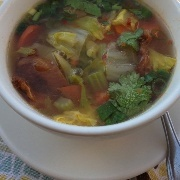
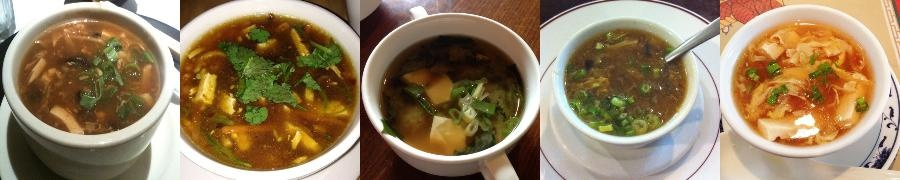
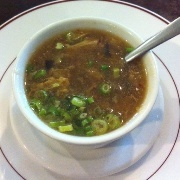
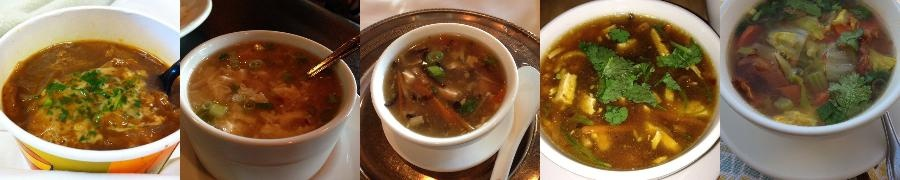

In [88]:
HTML('./topk_similarity.html')